## Kevin Qualls - DATA 1030 - Project Proposal - Due Sep. 30, 2019

In [71]:
# import packages
import pandas as pd

from datetime import datetime

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import sklearn.metrics 

from sklearn.impute import SimpleImputer

import numpy as np 

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# matplotlib - customizable plots
import matplotlib
from matplotlib import pylab as plt
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error 

from sklearn.linear_model import Ridge

from matplotlib import pyplot 

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib

# Step 1: Load Dataset ~ 10 seconds

In [72]:
# Load data sets
cab_rides = pd.read_csv("cab_rides.csv") 

# delete GMT timezone, and timestamp
del cab_rides['Date_GMT']
del cab_rides['Time_GMT']
del cab_rides['time_stamp']
del cab_rides['id']
del cab_rides['product_id']
del cab_rides['name']

# split Date_EST column into Day of Week, Day, Year
cab_rides = pd.concat([cab_rides,cab_rides.Date_EST.str.split(',',expand=True)],1)
cab_rides.rename(columns={0:'Day of Week'}, inplace=True)
cab_rides.rename(columns={1:'Month_Day'}, inplace=True)
cab_rides.rename(columns={2:'Year'}, inplace=True)

# delete Date_EST column now
del cab_rides['Date_EST']

# separate Time_EST column to find time
time = cab_rides["Time_EST"].str.split(" ", n = 1, expand = True)
cab_rides["Time"] = time[1]

# delete Time_EST column 
del cab_rides['Time_EST']

# Rush Hour

# make a new column for hour
Hour = cab_rides["Time"].str.split(":", n = 1, expand = True)
cab_rides['Hour'] = Hour[0]

# make a new column for rush hour 8 AM - 9:59 AM and 5 PM - 6:59 PM
cab_rides['Hour'] = pd.to_numeric(cab_rides['Hour'], errors='coerce') # convert Hour column to numeric
cab_rides['Rush_Hour'] = np.where((cab_rides['Hour']== 8) | (cab_rides['Hour']== 9)|
                           (cab_rides['Hour']== 17) | (cab_rides['Hour']== 18),'yes', 'no') 

# delete Hour column 
del cab_rides['Hour']

# delete Time column 
del cab_rides['Time']

In [73]:
cab_rides[1:8]

,distance,cab_type,destination,source,price,surge_multiplier,Day of Week,Month_Day,Year,Rush_Hour
1,1.74,Lyft,North End,Theatre District,30.0,1.0,Sunday,November 25,2018,no
2,2.01,Lyft,South Station,North Station,16.5,1.0,Sunday,November 25,2018,no
3,2.30,Uber,Back Bay,Haymarket Square,33.0,1.0,Sunday,November 25,2018,no
4,4.32,Lyft,Northeastern University,Financial District,22.5,1.0,Sunday,November 25,2018,no
5,1.16,Uber,Theatre District,Haymarket Square,NaN,1.0,Sunday,November 25,2018,no
6,2.31,Lyft,Haymarket Square,Back Bay,16.5,1.0,Sunday,November 25,2018,no
7,3.03,Lyft,Theatre District,Boston University,34.0,1.0,Sunday,November 25,2018,no


# Step 2: Delete Rows with Missing Values (All from Label)

In [74]:
# algorithm will automatically ignore values
# target varirable: price: regression model
# when the only missing values are from the label, it's ok to delete, because we're trying to predict them

In [75]:
cab_rides.isnull().sum()

distance                0
cab_type                0
destination             0
source                  0
price               55095
surge_multiplier        0
Day of Week             0
Month_Day               0
Year                    0
Rush_Hour               0
dtype: int64

In [76]:
price_missing = cab_rides.isnull().sum()[4]
total_rows = cab_rides.shape[0]
percent_missing = (price_missing/total_rows)*100
percent_missing

7.949402009317949

In [77]:
cab_rides = cab_rides.dropna()

In [78]:
# reset index
cab_rides = cab_rides.reset_index(drop=True)

# Step 3: EDA

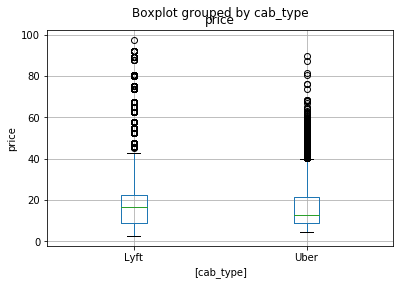

In [79]:
# Plot 1: Price vs. Cab_Type

cab_rides[['price','cab_type']].boxplot(by='cab_type')
plt.ylabel('price')
plt.show()

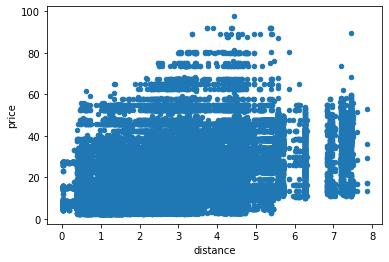

In [80]:
cab_rides.plot.scatter('distance','price')
plt.show()

# no linear relationship

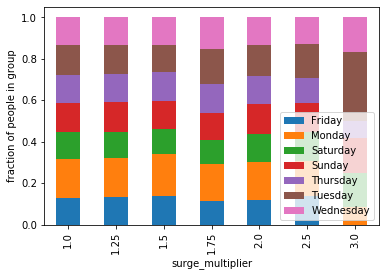

In [81]:
# Plot 1: Cab_Type vs. Day of Week
count_matrix = cab_rides.groupby(['surge_multiplier', 'Day of Week']).size().unstack()
# print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
# print(count_matrix_norm)

# stacked bar plot
count_matrix_norm.plot(kind='bar', stacked=True)
plt.ylabel('fraction of people in group')
plt.legend(loc=4)
plt.show()

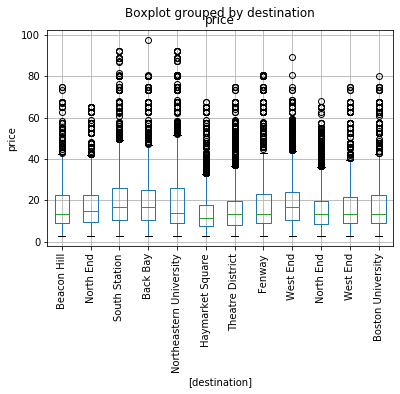

In [82]:
# Plot 2: Price vs. Destination

cab_rides[['price','destination']].boxplot(by='destination')
plt.ylabel('price')
plt.xticks(plt.xticks()[0], cab_rides.destination, rotation=90)
plt.show()

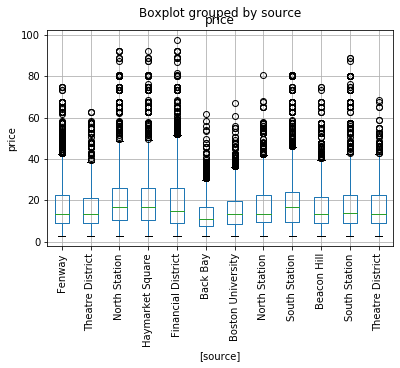

In [83]:
# Plot 3: Price vs. Source

cab_rides[['price','source']].boxplot(by='source')
plt.ylabel('price')
plt.xticks(plt.xticks()[0], cab_rides.source, rotation=90)
plt.show()

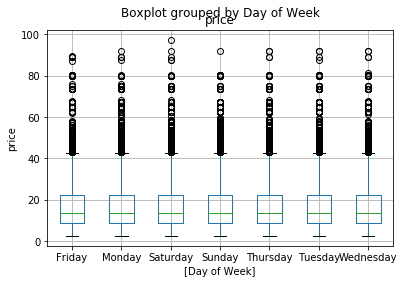

In [84]:
# Plot 4: Price vs. Day of Week

cab_rides[['price','Day of Week']].boxplot(by='Day of Week')
plt.ylabel('price')
plt.show()

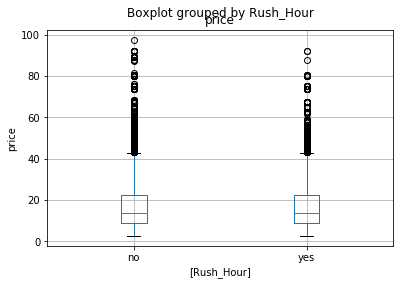

In [85]:
# Plot 5: Price vs. Rush_Hour

cab_rides[['price','Rush_Hour']].boxplot(by='Rush_Hour')
plt.ylabel('price')
plt.show()

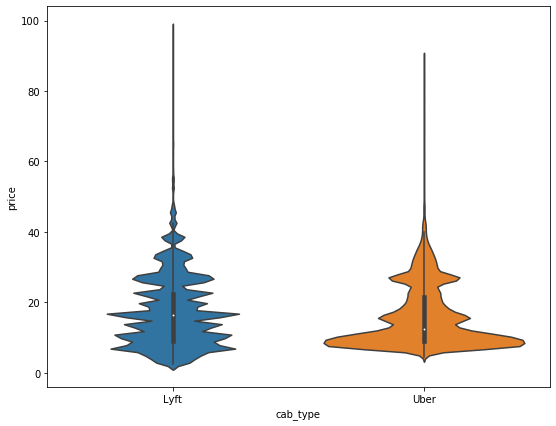

In [86]:
fig, ax = pyplot.subplots(figsize =(9, 7)) 
sns.violinplot(ax = ax, x = cab_rides["cab_type"],  
                  y = cab_rides["price"] ) 
pyplot.show()

# Step 4: Split Data into Train, Test, and CV Sets

In [87]:
# take random sample of rows and remove them from the original data by dropping index values

cab_copy = cab_rides.copy() # 100%

le = LabelEncoder()

train_set = cab_copy.sample(frac=0.60, random_state=0) # 60 % ## fit transform
le_array_train = le.fit_transform(train_set[['price']]) # array
le_df_train = pd.DataFrame(le_array_train, columns = ['price']) # data frame

leftover = cab_copy.drop(train_set.index) # 40 %

test_set = leftover.sample(frac=0.50, random_state=0) # 20 %  # apply .transform
le_array_test = le.fit_transform(test_set[['price']]) # array
le_df_test = pd.DataFrame(le_array_test, columns = ['price']) # data frame

cv_set = leftover.drop(test_set.index) # 20 %  # apply .transform
le_array_cv = le.fit_transform(cv_set[['price']]) # array
le_df_cv = pd.DataFrame(le_array_cv, columns = ['price']) # data frame

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Step 5: Preprocess Train, Test and CV Data Sets

In [88]:
# Train

In [89]:
# One-Hot Encoder
oh_enc = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
oh_array_train = oh_enc.fit_transform(train_set[['cab_type', 'destination', 'source', 
                                           'Day of Week', 'Rush_Hour']]) # fit, transform
col_names = oh_enc.get_feature_names() # return column names
oh_df_train = pd.DataFrame(oh_array_train, columns = col_names) 


# Ordinal Encoder
od_enc = OrdinalEncoder()
od_array_train = od_enc.fit_transform(train_set[['Month_Day']])
od_df_train = pd.DataFrame(od_array_train, columns = ['Month_Day']) 

# MinMaxScaler
mm_scaler = MinMaxScaler()
mm_array_train = mm_scaler.fit_transform(train_set[['Year']]) # array
mm_df_train = pd.DataFrame(mm_array_train, columns = ['Year']) 

# StandardScaler
sd_scaler = StandardScaler()
sd_array_train = sd_scaler.fit_transform(train_set[['distance','surge_multiplier']]) # array
sd_df_train = pd.DataFrame(sd_array_train, columns = ['distance',  'surge_multiplier']) 

# Save the preprocessed data into a pandas dataframe (1 point)
df_merge_train = pd.concat([oh_df_train, od_df_train, mm_df_train, 
                      sd_df_train, le_df_train], axis = 1) # merge data frames

Y_train = df_merge_train['price'] # y-value of train data set
X_train = df_merge_train.drop('price', 1) 

In [90]:
# Test

In [91]:
# One-Hot Encoder

oh_array_test = oh_enc.transform(test_set[['cab_type', 'destination', 'source', 
                                           'Day of Week', 'Rush_Hour']]) # fit, transform
col_names = oh_enc.get_feature_names() # return column names
oh_df_test = pd.DataFrame(oh_array_test, columns = col_names) 


# Ordinal Encoder
od_array_test = od_enc.transform(test_set[['Month_Day']])
od_df_test = pd.DataFrame(od_array_test, columns = ['Month_Day']) 

# MinMaxScaler
mm_array_test = mm_scaler.transform(test_set[['Year']]) # array
mm_df_test = pd.DataFrame(mm_array_test, columns = ['Year']) 

# StandardScaler
sd_array_test = sd_scaler.transform(test_set[['distance','surge_multiplier']]) # array
sd_df_test = pd.DataFrame(sd_array_test, columns = ['distance',  'surge_multiplier']) 


# Save the preprocessed data into a pandas dataframe (1 point)
df_merge_test = pd.concat([oh_df_test, od_df_test, mm_df_test, 
                      sd_df_test, le_df_test], axis = 1) # merge data frames


Y_test = df_merge_test['price'] # y-value of test data set
X_test = df_merge_test.drop('price', 1)

In [92]:
# CV

In [93]:
# One-Hot Encoder
oh_array_cv = oh_enc.transform(cv_set[['cab_type', 'destination', 'source', 
                                           'Day of Week', 'Rush_Hour']]) # fit, transform
col_names = oh_enc.get_feature_names() # return column names
oh_df_cv = pd.DataFrame(oh_array_cv, columns = col_names) 

# Ordinal Encoder
od_array_cv = od_enc.transform(cv_set[['Month_Day']])
od_df_cv = pd.DataFrame(od_array_cv, columns = ['Month_Day']) 

# MinMaxScaler
mm_array_cv = mm_scaler.transform(cv_set[['Year']]) # array
mm_df_cv = pd.DataFrame(mm_array_cv, columns = ['Year']) 

# StandardScaler
sd_array_cv = sd_scaler.transform(cv_set[['distance','surge_multiplier']]) # array
sd_df_cv = pd.DataFrame(sd_array_cv, columns = ['distance',  'surge_multiplier']) 

# Save the preprocessed data into a pandas dataframe (1 point)
df_merge_cv = pd.concat([oh_df_cv, od_df_cv, mm_df_cv, 
                      sd_df_cv, le_df_cv], axis = 1) # merge data frames


Y_cv = df_merge_cv['price'] # y-value of test data set
X_cv = df_merge_cv.drop('price', 1)

In [94]:
# Use df_merge_test data set

In [95]:
# correlation between price and all the other features

# first make a data frame without the target variable
df_no_target = df_merge_cv.drop("price", axis=1)

# find the correlation between sale price and each column of the "df_no_target" data frame
c1 = df_no_target.apply(lambda x: x.corr(df_merge_cv.price))

# reference: StackOverFlow 
# https://stackoverflow.com/questions/52497451/compute-correlation-between-features-and-target-variable

In [96]:
# top features that are most negatively correlated
c1.nsmallest(3)

x2_Haymarket Square   -0.093441
x0_Uber               -0.083960
x1_Haymarket Square   -0.074558
dtype: float64

In [97]:
c1.nlargest(3)

distance            0.341188
surge_multiplier    0.225228
x0_Lyft             0.083960
dtype: float64

# Step 6: Methods

In [98]:
# Linear Regression, Feature Engineering, Random Forest Regression, XGBoost

## Baseline

In [99]:
Y_value = np.mean(Y_train)
Y_value

29.770929448830415

In [100]:
Y_test.shape

(127595,)

In [101]:
# turn into an array with shape of Y-test
Y_pred_base = np.full((127595,), Y_value)
Y_pred_base.shape

(127595,)

# Linear Regression

In [102]:
# focus on highly correlated features

x_train_copy = X_train[['distance','surge_multiplier']]
# x_train_copy['ratio'] = (x_train_copy['distance'] / x_train_copy['surge_multiplier']).tolist()

x_test_copy = X_test[['distance','surge_multiplier']]
# x_test_copy['ratio'] = (x_test_copy['distance'] / x_test_copy['surge_multiplier']).tolist()

# Linear Regression

C = np.logspace(0, 4, 5)
lin_regressor = LinearRegression()  # create object for the class
lin_regressor.fit(x_train_copy, Y_train)  # perform linear regression
predictions = lin_regressor.predict(x_test_copy)  # make predictions

y_train_pred = lin_regressor.predict(x_train_copy) # predict y-value from X-train
y_test_pred = lin_regressor.predict(x_test_copy) # predict y-value from X-test

# Mean Squared Error
mse_linreg = mean_squared_error(Y_test,y_test_pred) 

In [103]:
mse_linreg

303.9877218642649

In [104]:
# regular
sklearn.metrics.r2_score(Y_test,y_test_pred)

0.16052456400032566

In [105]:
# baseline
sklearn.metrics.r2_score(y_test_pred,Y_pred_base)

-2.1904924195847997e-05

# Feature Engineering

In [106]:
# feature-engineering - gain more information 

x_train_copy = X_train[['distance','surge_multiplier']]
x_train_copy['ratio'] = (x_train_copy['distance'] / x_train_copy['surge_multiplier']).tolist()

x_test_copy = X_test[['distance','surge_multiplier']]
x_test_copy['ratio'] = (x_test_copy['distance'] / x_test_copy['surge_multiplier']).tolist()

# Linear Regression

lin_regressor = LinearRegression()  # create object for the class
lin_regressor.fit(x_train_copy, Y_train)  # perform linear regression
predictions = lin_regressor.predict(x_test_copy)  # make predictions

y_train_pred = lin_regressor.predict(x_train_copy) # predict y-value from X-train
y_test_pred = lin_regressor.predict(x_test_copy) # predict y-value from X-test

# Mean Squared Error
mse_linreg = mean_squared_error(Y_test,y_test_pred) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [107]:
mse_linreg

303.3889473155828

In [108]:
sklearn.metrics.r2_score(Y_test,y_test_pred)

0.16217810619682538

In [109]:
# baseline
sklearn.metrics.r2_score(y_test_pred,Y_pred_base)

-2.187230950512209e-05

# Random Forest Regression

In [110]:
# create regressor object 

regressor = RandomForestRegressor(n_estimators = 1, random_state = 0, max_depth = 6, n_jobs = -1) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, Y_train)
predictions = regressor.predict(X_test)

y_train_pred = regressor.predict(X_train) # predict y-value from X-train
y_test_pred = regressor.predict(X_test) # predict y-value from X-test

# Step 3: Mean Squared Error
mse_rfr = mean_squared_error(Y_test,y_test_pred) 

In [111]:
mse_rfr

301.2410069211505

In [112]:
sklearn.metrics.r2_score(Y_test,y_test_pred)

0.16810973786951033

In [113]:
# baseline
sklearn.metrics.r2_score(y_test_pred,Y_pred_base)

-5.4334903309527505e-05

## Tune parameters

In [114]:
# create regressor object 

regressor = RandomForestRegressor(n_estimators = 20, random_state = 0, max_depth = 20, n_jobs = -1) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, Y_train)
predictions = regressor.predict(X_test)

y_train_pred = regressor.predict(X_train) # predict y-value from X-train
y_test_pred = regressor.predict(X_test) # predict y-value from X-test

# Step 3: Mean Squared Error
mse_rfr = mean_squared_error(Y_test,y_test_pred)

In [115]:
mse_rfr

328.6055353552014

In [116]:
sklearn.metrics.r2_score(Y_test,y_test_pred)

0.09254139156518926

In [117]:
# baseline
sklearn.metrics.r2_score(y_test_pred,Y_pred_base)

-2.3141875036269965e-05

In [118]:
# create regressor object 

regressor = RandomForestRegressor(n_estimators = 5, random_state = 0, max_depth = 10, n_jobs = -1) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, Y_train)
predictions = regressor.predict(X_test)

y_train_pred = regressor.predict(X_train) # predict y-value from X-train
y_test_pred = regressor.predict(X_test) # predict y-value from X-test

# Step 3: Mean Squared Error
mse_rfr = mean_squared_error(Y_test,y_test_pred) 

In [119]:
mse_rfr

302.3099497822961

In [120]:
sklearn.metrics.r2_score(Y_test,y_test_pred)

0.16515780524237722

In [121]:
# baseline
sklearn.metrics.r2_score(y_test_pred,Y_pred_base)

-3.1539991274476264e-05

In [122]:
# create regressor object 

regressor = RandomForestRegressor(n_estimators = 10, random_state = 0, max_depth = 15, n_jobs = -1) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, Y_train)
predictions = regressor.predict(X_test)

y_train_pred = regressor.predict(X_train) # predict y-value from X-train
y_test_pred = regressor.predict(X_test) # predict y-value from X-test

# Step 3: Mean Squared Error
mse_rfr = mean_squared_error(Y_test,y_test_pred) 

In [123]:
mse_rfr

312.01725037124663

In [124]:
sklearn.metrics.r2_score(Y_test,y_test_pred)

0.13835066861095824

In [125]:
# baseline
sklearn.metrics.r2_score(y_test_pred,Y_pred_base)

-1.9498926715932896e-05

# XGBoost

In [126]:
import xgboost as xgb
# Reference: https://www.datacamp.com/community/tutorials/xgboost-in-python

In [127]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [149]:
xg_reg.fit(X_train,Y_train)

preds = xg_reg.predict(X_test)

mse = (mean_squared_error(Y_test, preds))

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[02:28:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [150]:
print("MSE: %f" % (mse))

MSE: 398.213144


In [151]:
sklearn.metrics.r2_score(Y_test,preds)

-0.09968307510059393

In [152]:
# baseline
sklearn.metrics.r2_score(preds,Y_pred_base)

-10.244117554139136

# SVM (Can't do - takes too long - 693,000 rows of data)

from sklearn.svm import SVC
from sklearn import svm

# Can't do K Fold Validation - do simple pipeline

In [132]:
feature_names = []
for col in X_test.columns: 
    print(col)
    feature_names.append(col)

x0_Lyft
x0_Uber
x1_Back Bay
x1_Beacon Hill
x1_Boston University
x1_Fenway
x1_Financial District
x1_Haymarket Square
x1_North End
x1_North Station
x1_Northeastern University
x1_South Station
x1_Theatre District
x1_West End
x2_Back Bay
x2_Beacon Hill
x2_Boston University
x2_Fenway
x2_Financial District
x2_Haymarket Square
x2_North End
x2_North Station
x2_Northeastern University
x2_South Station
x2_Theatre District
x2_West End
x3_Friday
x3_Monday
x3_Saturday
x3_Sunday
x3_Thursday
x3_Tuesday
x3_Wednesday
x4_no
x4_yes
Month_Day
Year
distance
surge_multiplier


In [133]:
#  Read in the data

label = 'price'

# balance of dataset
y = Y_test
X = X_test

classes, counts = np.unique(y,return_counts=True)
print('balance:',np.max(counts/len(y)))

balance: 0.08170382851992633


In [134]:
def ML_pipeline_basic(cab_rides,random_state):
    # split the data
    
    cab_copy = cab_rides.copy() # 100%

    le = LabelEncoder()

    train_set = cab_copy.sample(frac=0.60, random_state=0) # 60 % ## fit transform
    le_array_train = le.fit_transform(train_set[['price']]) # array
    le_df_train = pd.DataFrame(le_array_train, columns = ['price']) # data frame

    leftover = cab_copy.drop(train_set.index) # 40 %

    test_set = leftover.sample(frac=0.50, random_state=0) # 20 %  # apply .transform
    le_array_test = le.fit_transform(test_set[['price']]) # array
    le_df_test = pd.DataFrame(le_array_test, columns = ['price']) # data frame

    cv_set = leftover.drop(test_set.index) # 20 %  # apply .transform
    le_array_cv = le.fit_transform(cv_set[['price']]) # array
    le_df_cv = pd.DataFrame(le_array_cv, columns = ['price']) # data frame
    
    # Train
    
    # One-Hot Encoder
    oh_enc = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
    oh_array_train = oh_enc.fit_transform(train_set[['cab_type', 'destination', 'source', 
                                               'Day of Week', 'Rush_Hour']]) # fit, transform
    col_names = oh_enc.get_feature_names() # return column names
    oh_df_train = pd.DataFrame(oh_array_train, columns = col_names) 


    # Ordinal Encoder
    od_enc = OrdinalEncoder()
    od_array_train = od_enc.fit_transform(train_set[['Month_Day']])
    od_df_train = pd.DataFrame(od_array_train, columns = ['Month_Day']) 

    # MinMaxScaler
    mm_scaler = MinMaxScaler()
    mm_array_train = mm_scaler.fit_transform(train_set[['Year']]) # array
    mm_df_train = pd.DataFrame(mm_array_train, columns = ['Year']) 

    # StandardScaler
    sd_scaler = StandardScaler()
    sd_array_train = sd_scaler.fit_transform(train_set[['distance','surge_multiplier']]) # array
    sd_df_train = pd.DataFrame(sd_array_train, columns = ['distance',  'surge_multiplier']) 

    # Save the preprocessed data into a pandas dataframe (1 point)
    df_merge_train = pd.concat([oh_df_train, od_df_train, mm_df_train, 
                          sd_df_train, le_df_train], axis = 1) # merge data frames

    Y_train = df_merge_train['price'] # y-value of train data set
    X_train = df_merge_train.drop('price', 1) 

    # Test
    
    # One-Hot Encoder

    oh_array_test = oh_enc.transform(test_set[['cab_type', 'destination', 'source', 
                                               'Day of Week', 'Rush_Hour']]) # fit, transform
    col_names = oh_enc.get_feature_names() # return column names
    oh_df_test = pd.DataFrame(oh_array_test, columns = col_names) 


    # Ordinal Encoder
    od_array_test = od_enc.transform(test_set[['Month_Day']])
    od_df_test = pd.DataFrame(od_array_test, columns = ['Month_Day']) 

    # MinMaxScaler
    mm_array_test = mm_scaler.transform(test_set[['Year']]) # array
    mm_df_test = pd.DataFrame(mm_array_test, columns = ['Year']) 

    # StandardScaler
    sd_array_test = sd_scaler.transform(test_set[['distance','surge_multiplier']]) # array
    sd_df_test = pd.DataFrame(sd_array_test, columns = ['distance',  'surge_multiplier']) 


    # Save the preprocessed data into a pandas dataframe (1 point)
    df_merge_test = pd.concat([oh_df_test, od_df_test, mm_df_test, 
                          sd_df_test, le_df_test], axis = 1) # merge data frames


    Y_test = df_merge_test['price'] # y-value of test data set
    X_test = df_merge_test.drop('price', 1)
    
    
    # CV
    # One-Hot Encoder
    oh_array_cv = oh_enc.transform(cv_set[['cab_type', 'destination', 'source', 
                                               'Day of Week', 'Rush_Hour']]) # fit, transform
    col_names = oh_enc.get_feature_names() # return column names
    oh_df_cv = pd.DataFrame(oh_array_cv, columns = col_names) 

    # Ordinal Encoder
    od_array_cv = od_enc.transform(cv_set[['Month_Day']])
    od_df_cv = pd.DataFrame(od_array_cv, columns = ['Month_Day']) 

    # MinMaxScaler
    mm_array_cv = mm_scaler.transform(cv_set[['Year']]) # array
    mm_df_cv = pd.DataFrame(mm_array_cv, columns = ['Year']) 

    # StandardScaler
    sd_array_cv = sd_scaler.transform(cv_set[['distance','surge_multiplier']]) # array
    sd_df_cv = pd.DataFrame(sd_array_cv, columns = ['distance',  'surge_multiplier']) 

    # Save the preprocessed data into a pandas dataframe (1 point)
    df_merge_cv = pd.concat([oh_df_cv, od_df_cv, mm_df_cv, 
                          sd_df_cv, le_df_cv], axis = 1) # merge data frames


    Y_CV = df_merge_cv['price'] # y-value of test data set
    X_CV = df_merge_cv.drop('price', 1)
    
    
    
    # tune ridge hyper-parameter, alpha
    alpha = np.logspace(-3,4,num=8)
    train_score = []
    CV_score = []
    regs = []
    for a in alpha:
        reg = Ridge(alpha = a)
        reg.fit(X_train,Y_train)
        train_score.append(mean_squared_error(Y_train,reg.predict(X_train)))
        CV_score.append(mean_squared_error(Y_CV,reg.predict(X_CV)))
        regs.append(reg)
    # find the best alpha
    best_alpha = alpha[np.argmin(CV_score)]
    # grab the best model
    reg = regs[np.argmin(CV_score)]
    # calculate holdout score
    test_score = mean_squared_error(Y_test,reg.predict(X_test))
    return best_alpha,np.min(CV_score),test_score

In [135]:
CV_scores = []
test_scores = []
for i in range(5):
    best_alpha, CV_score, test_score = ML_pipeline_basic(cab_rides, i*42 )
    CV_scores.append(CV_score)
    test_scores.append(test_score)
    
print('CV MSE:',np.around(np.mean(CV_scores),2),'+/-',np.around(np.std(CV_scores),2))
print('test MSE:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

CV MSE: 311.66 +/- 0.0
test MSE: 302.54 +/- 0.0


# Feature Importance

In [136]:
# permutation

In [137]:
# create regressor object 

regressor = RandomForestRegressor(n_estimators = 1, random_state = 0, max_depth = 6, n_jobs = -1) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, Y_train)
regressor.feature_importances_
predictions = regressor.predict(X_test)

y_train_pred = regressor.predict(X_train) # predict y-value from X-train
y_test_pred = regressor.predict(X_test) # predict y-value from X-test

# Step 3: Mean Squared Error
mse_rfr = mean_squared_error(Y_test,y_test_pred) 

In [138]:
X_train.columns

Index(['x0_Lyft', 'x0_Uber', 'x1_Back Bay', 'x1_Beacon Hill',
       'x1_Boston University', 'x1_Fenway', 'x1_Financial District',
       'x1_Haymarket Square', 'x1_North End', 'x1_North Station',
       'x1_Northeastern University', 'x1_South Station', 'x1_Theatre District',
       'x1_West End', 'x2_Back Bay', 'x2_Beacon Hill', 'x2_Boston University',
       'x2_Fenway', 'x2_Financial District', 'x2_Haymarket Square',
       'x2_North End', 'x2_North Station', 'x2_Northeastern University',
       'x2_South Station', 'x2_Theatre District', 'x2_West End', 'x3_Friday',
       'x3_Monday', 'x3_Saturday', 'x3_Sunday', 'x3_Thursday', 'x3_Tuesday',
       'x3_Wednesday', 'x4_no', 'x4_yes', 'Month_Day', 'Year', 'distance',
       'surge_multiplier'],
      dtype='object')

In [171]:
y_values = regressor.feature_importances_
x_values = X_train.columns
feature_data = list(zip(X_train.columns,ft_importances))

In [178]:
feature_data

[('x0_Lyft', 0.004573778095417177),
 ('x0_Uber', 0.003768291629825923),
 ('x1_Back Bay', 0.00041609512658368424),
 ('x1_Beacon Hill', 0.0020384306304468696),
 ('x1_Boston University', 0.0),
 ('x1_Fenway', 0.0),
 ('x1_Financial District', 0.0),
 ('x1_Haymarket Square', 0.0),
 ('x1_North End', 0.0),
 ('x1_North Station', 0.0),
 ('x1_Northeastern University', 0.0),
 ('x1_South Station', 0.000511414509709705),
 ('x1_Theatre District', 0.00027568304396785793),
 ('x1_West End', 0.0),
 ('x2_Back Bay', 0.0),
 ('x2_Beacon Hill', 0.0033391189233535866),
 ('x2_Boston University', 0.00042355531936565826),
 ('x2_Fenway', 0.0),
 ('x2_Financial District', 0.0006102528282595477),
 ('x2_Haymarket Square', 0.0),
 ('x2_North End', 0.0021260774150338555),
 ('x2_North Station', 0.0),
 ('x2_Northeastern University', 0.0003460501235350422),
 ('x2_South Station', 0.000165968086566215),
 ('x2_Theatre District', 0.0),
 ('x2_West End', 0.00020049377023503116),
 ('x3_Friday', 0.0),
 ('x3_Monday', 0.00023695217051

In [176]:
df = pd.DataFrame(y_values, index=x_values)

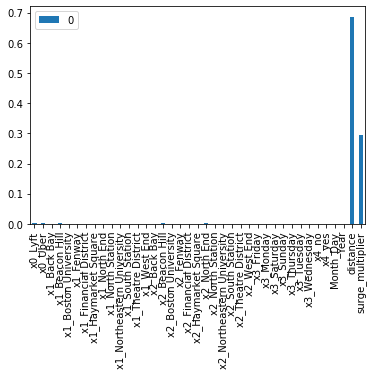

In [183]:
ax = df.plot.bar()